In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge

In [26]:
# Load dataset
car_data = pd.read_csv('/content/data.csv')
car_data.head()


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.00,6.00,MANUAL,rear wheel drive,2.00,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.00,6.00,MANUAL,rear wheel drive,2.00,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.00,6.00,MANUAL,rear wheel drive,2.00,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.00,6.00,MANUAL,rear wheel drive,2.00,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.00,6.00,MANUAL,rear wheel drive,2.00,Luxury,Compact,Convertible,28,18,3916,34500


In [27]:
# Clean column names
car_data.columns = car_data.columns.str.lower().str.replace(' ', '_')

In [28]:
# Clean string columns
string_columns = list(car_data.dtypes[car_data.dtypes == 'object'].index)
for col in string_columns:
    car_data[col] = car_data[col].str.lower().str.replace(' ', '_')

In [29]:
# Rename MSRP to price
car_data.rename(columns={'msrp': 'price'}, inplace=True)

In [30]:
# Display statistics
pd.options.display.float_format = '{:.2f}'.format
print(car_data.describe())
print(car_data.describe(include=['O']))

          year  engine_hp  engine_cylinders  number_of_doors  highway_mpg  \
count 11914.00   11845.00          11884.00         11908.00     11914.00   
mean   2010.38     249.39              5.63             3.44        26.64   
std       7.58     109.19              1.78             0.88         8.86   
min    1990.00      55.00              0.00             2.00        12.00   
25%    2007.00     170.00              4.00             2.00        22.00   
50%    2015.00     227.00              6.00             4.00        26.00   
75%    2016.00     300.00              6.00             4.00        30.00   
max    2017.00    1001.00             16.00             4.00       354.00   

       city_mpg  popularity      price  
count  11914.00    11914.00   11914.00  
mean      19.73     1554.91   40594.74  
std        8.99     1441.86   60109.10  
min        7.00        2.00    2000.00  
25%       16.00      549.00   21000.00  
50%       18.00     1385.00   29995.00  
75%       22.00    

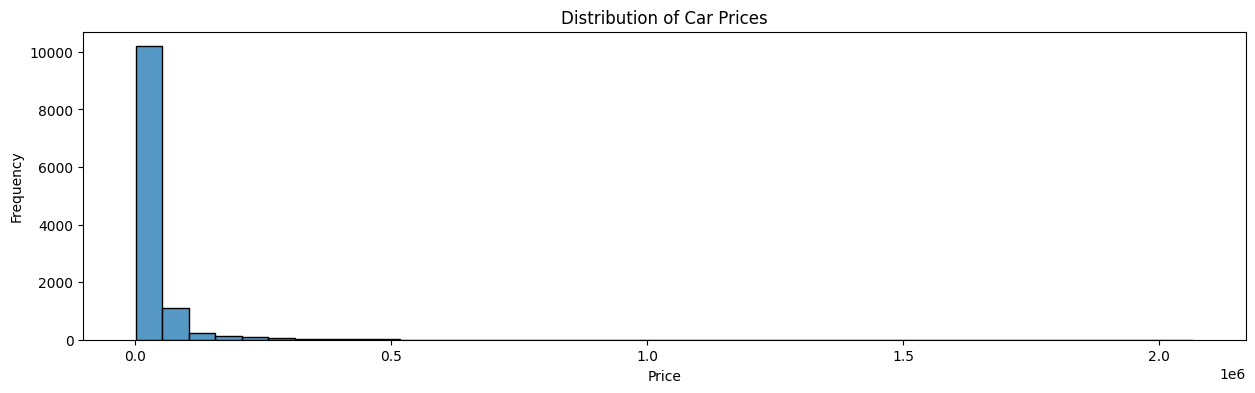

In [31]:
# Price distribution plot
plt.figure(figsize=(15, 4))
sns.histplot(car_data['price'], bins=40)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Car Prices')
plt.show()

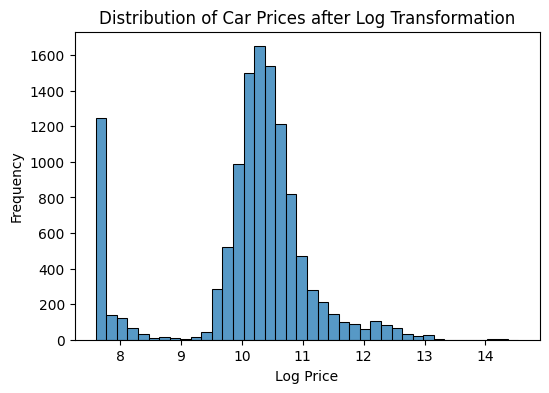

In [32]:
# Log transformation of prices
car_data['log_price'] = np.log1p(car_data['price'])
plt.figure(figsize=(6, 4))
sns.histplot(car_data['log_price'], bins=40)
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.title('Distribution of Car Prices after Log Transformation')
plt.show()

In [33]:
# Train-test split
np.random.seed(2)
n = len(car_data)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
idx = np.arange(n)
np.random.shuffle(idx)
car_data_shuffled = car_data.iloc[idx]
car_data_train = car_data_shuffled.iloc[:n_train].copy()
car_data_val = car_data_shuffled.iloc[n_train:n_train+n_val].copy()
car_data_test = car_data_shuffled.iloc[n_train+n_val:].copy()

In [34]:
# Prepare target variables
y_train = car_data_train.log_price.values
y_val = car_data_val.log_price.values

In [35]:
# Define base features for the model
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

In [36]:
# Prepare the training data
def prepare_X(car_data):
    car_data = car_data.copy()
    feature = base.copy()
    car_data['age'] = 2023 - car_data.year
    feature.append('age')
    car_data_num = car_data[feature]
    car_data_num = car_data_num.fillna(car_data_num.mean())
    x = car_data_num.values
    return x

In [37]:
# Train the model using Ridge regression
ridge_model = Ridge(alpha=1.0)
x_train = prepare_X(car_data_train)
ridge_model.fit(x_train, y_train)


Ridge()

In [38]:
# Prepare the validation data
x_val = prepare_X(car_data_val)
y_pred_val = ridge_model.predict(x_val)

In [39]:
# Create a DataFrame to compare actual vs predicted prices
comparison_df = pd.DataFrame({
    'Actual Price': np.expm1(y_val),  # Inverse of log transformation
    'Predicted Price': np.expm1(y_pred_val)  # Inverse of log transformation
    })

In [40]:
# Display the first few rows of the comparison
print("\n--- Actual vs Predicted Prices ---")
print(comparison_df.head())


--- Actual vs Predicted Prices ---
   Actual Price  Predicted Price
0      26885.00         28489.61
1      54650.00         42195.32
2      16775.00         24177.94
3      42600.00         52949.15
4      25995.00         28817.70


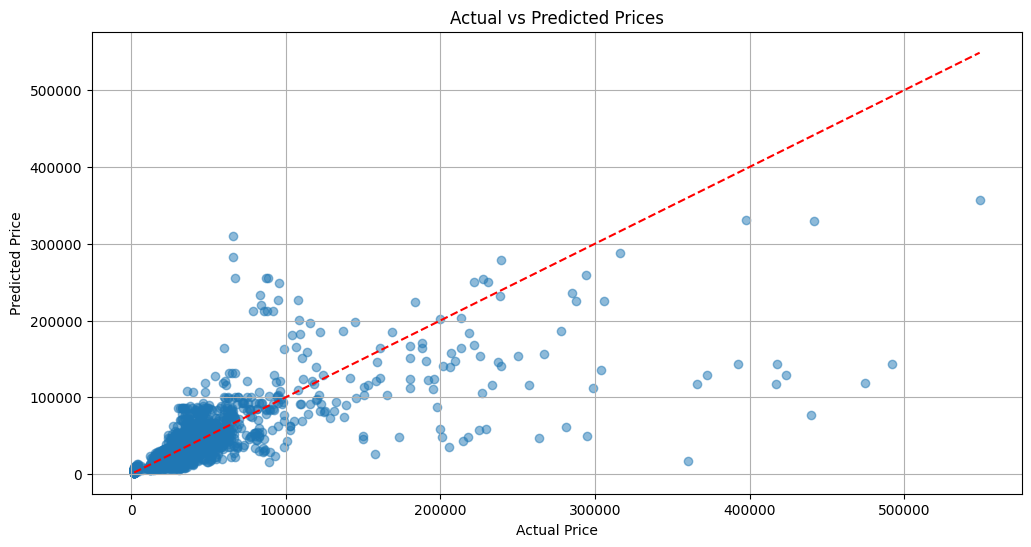

In [41]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.scatter(comparison_df['Actual Price'], comparison_df['Predicted Price'], alpha=0.5)
plt.plot([comparison_df['Actual Price'].min(), comparison_df['Actual Price'].max()],
         [comparison_df['Actual Price'].min(), comparison_df['Actual Price'].max()], 'r--')  # Line for perfect prediction
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.grid()
plt.show()

In [42]:
# Define the RMSE function
def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

In [43]:
# Calculate RMSE for validation
print("Validation RMSE:", calculate_rmse(np.expm1(y_val), np.expm1(y_pred_val)))

Validation RMSE: 32649.746130171734
